Latency test from a VM cha-gpu in us-central1-a to the cluster service internet2-test in us-central1-a

In [36]:
import logging
import grpc
import time
import numpy as np
import pandas as pd
import server_tools_pb2
import server_tools_pb2_grpc
from google.protobuf import empty_pb2
from matplotlib import pyplot as plt

PORT = '50051'

def run_facile(channel, data_send, num_data_send, batch_size):
    start_time = time.time()
    
    # Get a client ID which you need to talk to the server
    stub = server_tools_pb2_grpc.FacileServerStub(channel)
    try:
        response = stub.RequestClientID(server_tools_pb2.NullParam())
    except BaseException:
        print(
             """Connection to the server could not be established.
             Press enter to try again.""")
        return
    client_id = response.new_id
    finish_time = time.time()-start_time

    start_time = time.time()
    data_message = server_tools_pb2.DataMessage(
        client_id=client_id, data=data_send, batch_size=batch_size, num_data = num_data_send)
    response = stub.StartJobWait(data_message, 100, [])
    
    whole_time = time.time() - start_time
    server_time = response.server_time
    latency_time = whole_time-server_time
    latency_percentage = (1 -server_time / whole_time) * 100
    
    A = np.frombuffer(response.prediction,dtype = np.float32)
    print(list(np.frombuffer(response.prediction,dtype = np.float32))[:10])
    channel.close()
    return response.infer_time_CPU, response.infer_time_GPU, whole_time, latency_time, latency_percentage


def setup_server(host_IP):
    options = [('grpc.max_receive_message_length', 500*1024*1024 )]
    channel = grpc.insecure_channel(host_IP + ':' + PORT, options = options)
    return channel

In [37]:
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)
logging.basicConfig(level=logging.NOTSET)

start_time = time.time()
read_rec_hit = pd.read_pickle("input/X_HB.pkl")
read_rec_hit.drop(['PU', 'pt'], 1, inplace=True)
mu,std = np.mean(read_rec_hit, axis=0), np.std(read_rec_hit, axis=0)
read_rec_hit = (read_rec_hit-mu)/std

read_rec_hit = pd.concat([read_rec_hit]*100, ignore_index=True)


In [38]:
IP = "35.232.67.41"
n_event = 16000
gpu_time_list = []
latency_time_list = []
num_data_send_list = n_event*(2*(np.arange(20)+1))

for num_data_send in num_data_send_list:
    read_rec_hit_sliced = read_rec_hit[:num_data_send]
    num_data_send = len(read_rec_hit_sliced)
    start_time = time.time()
    compressed_data = read_rec_hit_sliced.values.tobytes()
    finish_time = time.time()-start_time
    print("Time reading data from local file (pandas->bytes) is ", finish_time)
    print(num_data_send)
    cpu_time, gpu_time, whole_time, latency_time, latency_percentage = run_facile(setup_server(IP), compressed_data, num_data_send, int(num_data_send/4))
    print("CPU TIME :", cpu_time*(1e9)/len(read_rec_hit_sliced), "ns per hit")
    #print("CPU TIME :", cpu_time*(1e3)*n_event/len(read_rec_hit_sliced), "ms per event") 
    gpu_time_list.append(gpu_time*(1e9)/len(read_rec_hit_sliced))
    print("GPU TIME :", gpu_time*(1e9)/len(read_rec_hit_sliced), "ns per hit")
    #print("GPU TIME :", gpu_time*(1e3)*n_event/len(read_rec_hit_sliced), "ms per event")  
    print("Whole time :", whole_time*(1e9)/len(read_rec_hit_sliced), "ns per hit")
    latency_time_list.append(latency_percentage)
    print("Latency time", latency_time*(1e9)/len(read_rec_hit_sliced), "ns per hit")
    print("Latency percentage", latency_percentage , '%')

Time reading data from local file (pandas->bytes) is  0.009319305419921875
16000
[0.1978267, 0.9550575, 31.810246, 1.0363286, 4.3504868, 4.1368265, 0.23492724, 23.075493, 3.4669783, 0.13345513]
CPU TIME : 2061.8736743927 ns per hit
GPU TIME : 337.6603126525879 ns per hit
Whole time : 16085.043549537659 ns per hit
Latency time 2437.084913253784 ns per hit
Latency percentage 15.151248461020394 %
Time reading data from local file (pandas->bytes) is  0.0061190128326416016
48000
[0.19782662, 0.95505786, 31.810246, 1.0363286, 4.350487, 4.136828, 0.23492703, 23.075493, 3.4669788, 0.13345513]
CPU TIME : 715.2954737345377 ns per hit
GPU TIME : 180.50273259480795 ns per hit
Whole time : 6058.20616086324 ns per hit
Latency time 1537.5614166259766 ns per hit
Latency percentage 25.379813360575497 %
Time reading data from local file (pandas->bytes) is  0.00955057144165039
80000
[0.19782662, 0.95505774, 31.810242, 1.0363286, 4.3504868, 4.1368275, 0.234927, 23.075493, 3.4669785, 0.13345513]
CPU TIME :

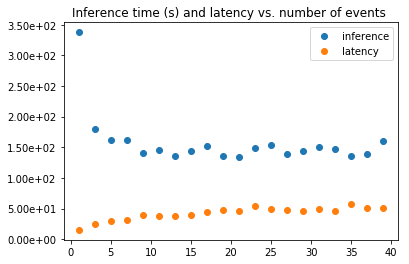

In [39]:
#N = 16000
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

import matplotlib.ticker as mtick

fig = plt.figure()

ax = fig.add_subplot(111)
num_data_send_list = num_data_send_list/n_event
ax.plot(num_data_send_list, gpu_time_list, 'o', label = 'inference')
ax.plot(num_data_send_list, latency_time_list, 'o', label = 'latency')
ax.legend()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.title("Inference time (ns) and latency vs. number of events ")
plt.show()